In [2]:
from __future__ import print_function, division
import os
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.spatial.transform import Rotation as R
from glob import glob
import cv2
import json

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data import sampler
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim


# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

NUM_TRAIN = 100000

plt.ion()

In [3]:
def show_pupil(image, centres):
    """Show image with pupil"""
    plt.imshow(image[0], cmap='gray')
    plt.scatter(centres[0], centres[1], s=20, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

In [4]:
def preprocess_unityeyes_image(img, json_data):
    ow = 160
    oh = 96
    # Prepare to segment eye image
    ih, iw = img.shape[:2]
    ih_2, iw_2 = ih/2.0, iw/2.0

    heatmap_w = int(ow/2)
    heatmap_h = int(oh/2)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    def process_coords(coords_list):
        coords = [eval(l) for l in coords_list]
        return np.array([(x, ih-y, z) for (x, y, z) in coords])
    
    interior_landmarks = process_coords(json_data['interior_margin_2d'])
    caruncle_landmarks = process_coords(json_data['caruncle_2d'])
    iris_landmarks = process_coords(json_data['iris_2d'])

    left_corner = np.mean(caruncle_landmarks[:, :2], axis=0)
    right_corner = interior_landmarks[8, :2]
    eye_width = 1.5 * abs(left_corner[0] - right_corner[0])
    eye_middle = np.mean([np.amin(interior_landmarks[:, :2], axis=0),
                          np.amax(interior_landmarks[:, :2], axis=0)], axis=0)

    # Normalize to eye width.
    scale = ow/eye_width

    translate = np.asmatrix(np.eye(3))
    translate[0, 2] = -eye_middle[0] * scale
    translate[1, 2] = -eye_middle[1] * scale

    rand_x = np.random.uniform(low=-10, high=10)
    rand_y = np.random.uniform(low=-10, high=10)
    recenter = np.asmatrix(np.eye(3))
    recenter[0, 2] = ow/2 + rand_x
    recenter[1, 2] = oh/2 + rand_y

    scale_mat = np.asmatrix(np.eye(3))
    scale_mat[0, 0] = scale
    scale_mat[1, 1] = scale

    angle = 0 #np.random.normal(0, 1) * 20 * np.pi/180
    rotation = R.from_rotvec([0, 0, angle]).as_matrix()

    transform = recenter * rotation * translate * scale_mat
    transform_inv = np.linalg.inv(transform)
    
    # Apply transforms
    eye = cv2.warpAffine(img, transform[:2], (ow, oh))

    rand_blur = np.random.uniform(low=0, high=20)
    eye = cv2.GaussianBlur(eye, (5, 5), rand_blur)

    # Normalize eye image
    eye = cv2.equalizeHist(eye)
    eye = eye.astype(np.float32)
    eye = eye / 255.0

    iris_center = np.mean(iris_landmarks[:, :2], axis=0)

    landmarks = np.concatenate([interior_landmarks[:, :2], 
                                iris_landmarks[::2, :2], 
                                iris_center.reshape((1, 2)),
                                [[iw_2, ih_2]],  
                                ])  

    landmarks = np.asmatrix(np.pad(landmarks, ((0, 0), (0, 1)), 'constant', constant_values=1))
    landmarks = np.asarray(landmarks * transform[:2].T) * np.array([heatmap_w/ow, heatmap_h/oh])
    landmarks = landmarks.astype(np.float32)

    return {'image' : eye.reshape((1, 96, 160)), 
            'centres' : landmarks[32] * 2}

In [5]:
class EyePupilDataset(Dataset):
    """Eye`s pupil dataset."""

    def __init__(self, img_dir=None, transform=None):

        if img_dir is None:
            img_dir = 'imgs'

        self.img_paths = glob(os.path.join(img_dir, '*.jpg'))
        self.img_paths = sorted(self.img_paths, key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))
        self.json_paths = []
        for img_path in self.img_paths:
            idx = os.path.splitext(os.path.basename(img_path))[0]
            self.json_paths.append(os.path.join(img_dir, f'{idx}.json'))
        self.transform = transform
        
    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        full_img = cv2.imread(self.img_paths[idx])
        with open(self.json_paths[idx]) as f:
            json_data = json.load(f)

        sample = preprocess_unityeyes_image(full_img, json_data)
        
        if self.transform:
            sample = self.transform(sample)

        return sample

In [6]:
eye_dataset = EyePupilDataset()

15 <class 'numpy.ndarray'> (2,)


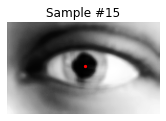

16 <class 'numpy.ndarray'> (2,)


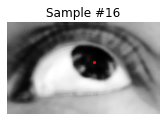

In [7]:
fig = plt.figure()
j = 0
for i in range(15, len(eye_dataset)):
    sample = eye_dataset[i]

    print(i, type(sample['image']), sample['centres'].shape)

    ax = plt.subplot(1, 2, j + 1)
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_pupil(**sample)
    j += 1

    if j == 2:
        plt.show()
        break

In [8]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, centres = sample['image'], sample['centres']
        return {'image': torch.from_numpy(image),
                'centres': torch.from_numpy(centres)}

In [9]:
transformed_dataset = EyePupilDataset(transform=ToTensor())

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['centres'].size())

    if i == 3:
        break

0 torch.Size([1, 96, 160]) torch.Size([2])
1 torch.Size([1, 96, 160]) torch.Size([2])
2 torch.Size([1, 96, 160]) torch.Size([2])
3 torch.Size([1, 96, 160]) torch.Size([2])


In [10]:
loader_train = DataLoader(transformed_dataset, batch_size=100,
                          shuffle=False, num_workers=6,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

loader_val = DataLoader(transformed_dataset, batch_size=100,
                        shuffle=False, num_workers=6,
                        sampler=sampler.SubsetRandomSampler(range(90000, 100001)))

In [11]:
USE_GPU = True

dtype = torch.float32 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [12]:
def flatten(x):
    N = x.shape[0] 
    return x.view(N, -1)  

In [13]:
def train(model, optimizer, epochs=30):
    """
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model losses during training.
    """
    model = model.to(device=device)
    i = 1
    for e in range(epochs):
        losses_tr = np.array([])
        for t, batch in enumerate(loader_train):
            model.train() 
            batch['image'] = batch['image'].to(device=device, dtype=dtype)  # move to device, e.g. GPU
            batch['centres'] = batch['centres'].to(device=device, dtype=dtype)

            scores = model(batch['image'])
            loss = F.mse_loss(scores, batch['centres'])
            losses_tr = np.append(losses_tr, loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        scheduler.step()

        print('Epoch %d, loss = %.4f' % (i, losses_tr.mean()))
        i += 1
        #check_loss(loader_val, model)
        print()

In [14]:
def check_loss(loader, model):
    model.eval() 
    losses = np.array([])
    with torch.no_grad():
        for batch in loader:
            batch['image'] = batch['image'].to(device=device, dtype=dtype) 
            batch['centres'] = batch['centres'].to(device=device, dtype=dtype)
            scores = model(batch['image'])
            loss = F.mse_loss(scores, batch['centres'])
            losses = np.append(losses, loss.item())
        print('Loss on val = %.4f' % losses.mean())

In [15]:
class PupilNet_v1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1)
        self.act1 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()
        self.conv3 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()
        self.conv4 = nn.Conv2d(16, 32, kernel_size=3, stride=2)
        self.act4 = nn.ReLU()
        self.drop1 = nn.Dropout2d()
        self.conv5 = nn.Conv2d(32, 64, kernel_size=3, stride=2)
        self.act5 = nn.ReLU()
        self.drop2 = nn.Dropout2d()
        self.conv6 = nn.Conv2d(64, 128, kernel_size=3, stride=2)
        self.act6 = nn.ReLU()
        self.drop3 = nn.Dropout2d()
        self.conv7 = nn.Conv2d(128, 256, kernel_size=3, stride=2)
        self.act7 = nn.ReLU()
        self.drop4 = nn.Dropout2d()
        self.global_pool = nn.AvgPool2d(kernel_size=(2, 4))
        self.fc = nn.Linear(256, 2)
        
    def forward(self, x):
        x = self.pool(self.act1(self.conv1(x)))
        res = self.act2(self.conv2(x))
        res = self.act3(self.conv3(res) + x)
        res = self.drop1(self.act4(self.conv4(res)))
        res = self.act5(self.conv5(res))
        res = self.drop3(self.act6(self.conv6(res)))
        res = self.act7(self.conv7(res))
        res = flatten(self.global_pool(res))
        res = self.fc(res)
        return res

In [16]:
class PupilNet_v2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1)
        self.act1 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_extra = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.act_extra = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2)
        self.act2 = nn.ReLU()
        self.drop1 = nn.Dropout2d()
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2)
        self.act3 = nn.ReLU()
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2)
        self.act4 = nn.ReLU()
        self.drop2 = nn.Dropout2d()
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=2)
        self.act5 = nn.ReLU()
        self.global_pool = nn.AvgPool2d(kernel_size=(2, 4))
        self.fc1 = nn.Linear(256, 64)
        self.act6 = nn.ReLU()
        self.fc2 = nn.Linear(64, 2)
        
    def forward(self, x):
        x = self.pool(self.act1(self.conv1(x)))
        x = self.act_extra(self.conv_extra(x))
        x = self.drop1(self.act2(self.conv2(x)))
        x = self.act3(self.conv3(x))
        x = self.drop2(self.act4(self.conv4(x)))
        x = self.act5(self.conv5(x))
        x = flatten(self.global_pool(x))
        x = self.fc2(self.act6(self.fc1(x)))
        return x

def test():
    x = torch.zeros((64, 1, 96, 160), dtype=dtype)
    model = PupilNet_v2()
    scores = model(x)
    print(scores.size())  # you should see [64, 2]
test()

torch.Size([64, 2])


In [17]:
class PupilNet_v3(nn.Module):
    def __init__(self):
        super().__init__()
        self.norm = nn.BatchNorm2d(1)
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3)
        self.act1 = nn.ReLU()
        self.conv2 = nn.Conv2d(8, 24, kernel_size=3)
        self.act2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(24, 36, kernel_size=3)
        self.act3 = nn.ReLU()
        self.conv4 = nn.Conv2d(36, 48, kernel_size=3)
        self.act4 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv5 = nn.Conv2d(48, 64, kernel_size=4)
        self.act5 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2 ,stride=2)
        self.conv6 = nn.Conv2d(64, 80, kernel_size=3, stride=2)
        self.act6 = nn.ReLU()
        self.conv7 = nn.Conv2d(80, 96, kernel_size=3)
        self.act7 = nn.ReLU()
        self.global_pool = nn.AvgPool2d(kernel_size=(2, 6))
        self.fc1 = nn.Linear(96, 36)
        self.act8 = nn.ReLU()
        self.fc2 = nn.Linear(36, 2)
        
    def forward(self, x):
        x = self.act1(self.conv1(self.norm(x)))
        x = self.pool1(self.act2(self.conv2(x)))
        x = self.act4(self.conv4(self.act3(self.conv3(x))))
        x = self.act5(self.conv5(self.pool2(x)))
        x = self.act6(self.conv6(self.pool3(x)))
        x = self.act7(self.conv7(x))
        x = flatten(self.global_pool(x))
        x = self.fc2(self.act8(self.fc1(x)))
        return x
    
def test():
    x = torch.zeros((64, 1, 96, 160), dtype=dtype)
    model = PupilNet_v3()
    scores = model(x)
    print(scores.size())  # you should see [64, 2]
test()

torch.Size([64, 2])


In [18]:
model = PupilNet_v2()
optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

In [18]:
train(model, optimizer)

Epoch 1, loss = 273.1923

Epoch 2, loss = 161.8132

Epoch 3, loss = 112.3184

Epoch 4, loss = 86.5149

Epoch 5, loss = 62.7379

Epoch 6, loss = 45.0592

Epoch 7, loss = 32.8980

Epoch 8, loss = 24.5798

Epoch 9, loss = 19.5962

Epoch 10, loss = 16.8034

Epoch 11, loss = 14.2331

Epoch 12, loss = 12.3551

Epoch 13, loss = 10.9620

Epoch 14, loss = 9.8034

Epoch 15, loss = 9.1211

Epoch 16, loss = 8.4419

Epoch 17, loss = 7.7174

Epoch 18, loss = 7.1978

Epoch 19, loss = 6.7121

Epoch 20, loss = 6.4555

Epoch 21, loss = 5.3680

Epoch 22, loss = 5.1535

Epoch 23, loss = 5.0541

Epoch 24, loss = 4.9671

Epoch 25, loss = 4.9571

Epoch 26, loss = 4.8639

Epoch 27, loss = 4.8686

Epoch 28, loss = 4.7782

Epoch 29, loss = 4.7689

Epoch 30, loss = 4.6908



In [124]:
check_loss(loader_val, model)

Loss on val = 10.7210


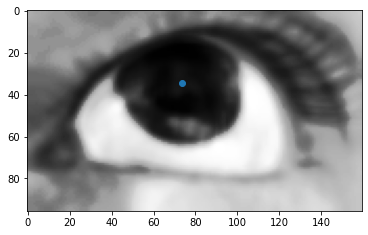

In [21]:
img = cv2.imread('imgs/1.jpg')
json_fn = open('imgs/1.json')
data = json.load(json_fn)
img = preprocess_unityeyes_image(img, data)['image']
eye_c = model(torch.Tensor(img).view(1, 1, 96, 160).to(device))
plt.scatter(eye_c[0][0].item(), eye_c[0][1].item())
plt.imshow(img[0], cmap='gray')

In [173]:
torch.save(model.state_dict(), 'pupilnet_v5.pt')